<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S5-Assignment-Solution/EVA8_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective / Target 

* Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include
* Write a single notebook file to run all the 3 models above for 20 epochs each
* Create these graphs:
  * Graph 1: Test/Validation Loss for all 3 models together
  * Graph 2: Test/Validation Accuracy for 3 models together
  * graphs must have proper annotation
* Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 


# Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR #scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


# Data Transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train / Test Split

In [4]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data', 
                      train=False, 
                      download=True, 
                      transform=test_transforms)

## Data Loader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Checking Dataloader

torch.Size([128, 1, 28, 28])
torch.Size([128])


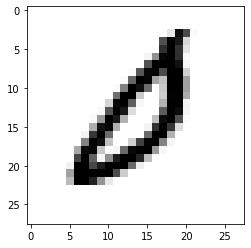

In [6]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

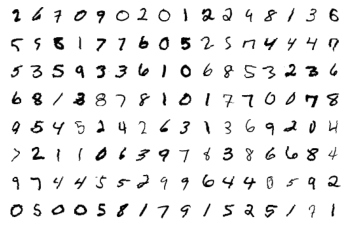

In [7]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Model

In [8]:
class Network(nn.Module):
  def __init__(self, norm = 'bn'):
    super(Network,self).__init__() # extending super class method
    
    drop_out_value = 0.1
    self.norm = norm

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,18,3 , bias= False ), # In- 1x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(18), # affine=False),
        # nn.Dropout(drop_out_value)
    ) 
    
    if self.norm == 'bn': self.normlayer1 = nn.BatchNorm2d(18)
    if self.norm == 'ln': self.normlayer1 = nn.LayerNorm([18,26,26]) 
    if self.norm == 'gn' : self.normlayer1 = nn.GroupNorm(2,18) # 2 groups of 9 channels each
    self.dropout1 = nn.Dropout(drop_out_value)

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(18,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),# affine=False),
        # nn.Dropout(drop_out_value)
    ) 

    if self.norm == 'bn': self.normlayer2 = nn.BatchNorm2d(16)
    if self.norm == 'ln': self.normlayer2 = nn.LayerNorm([16,24,24]) 
    if self.norm == 'gn' : self.normlayer2 = nn.GroupNorm(2,16) # 2 groups of 8 channels each
    self.dropout2 = nn.Dropout(drop_out_value)


    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),# affine=False),
        # nn.Dropout(drop_out_value)
    ) 

    if self.norm == 'bn': self.normlayer3 = nn.BatchNorm2d(16)
    if self.norm == 'ln': self.normlayer3 = nn.LayerNorm([16,22,22]) 
    if self.norm == 'gn' : self.normlayer3 = nn.GroupNorm(2,16) # 2 groups of 8 channels each
    self.dropout3 = nn.Dropout(drop_out_value)

    # Transition Block 1 (this also includes a conv block)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(32,16,1), # In- 32x12x12, Out- 16x12x12, RF- 8x8, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(16),
    #     nn.Dropout(drop_out_value)
    # ) 

    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),# affine=False),
        # nn.Dropout(drop_out_value)
    ) 

    if self.norm == 'bn': self.normlayer5 = nn.BatchNorm2d(16)
    if self.norm == 'ln': self.normlayer5 = nn.LayerNorm([16,9,9]) 
    if self.norm == 'gn' : self.normlayer5 = nn.GroupNorm(2,16) # 2 groups of 8 channels each
    self.dropout5 = nn.Dropout(drop_out_value)

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x9x9, Out- 16x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU()
        # ,
        # nn.BatchNorm2d(16),# affine=False),
        # nn.Dropout(drop_out_value)
    ) 

    if self.norm == 'bn': self.normlayer6 = nn.BatchNorm2d(16)
    if self.norm == 'ln': self.normlayer6 = nn.LayerNorm([16,7,7]) 
    if self.norm == 'gn' : self.normlayer6 = nn.GroupNorm(2,16) # 2 groups of 8 channels each
    self.dropout6 = nn.Dropout(drop_out_value)

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16,10,1, bias= False ), # In- 16x7x7, Out- 10x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        # nn.ReLU()
        # ,
        # nn.BatchNorm2d(10, affine=True),
        # nn.Dropout(drop_out_value)
    ) 

    self.gap = nn.AvgPool2d(7) # In- 10x7x7, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2


  def forward(self,x):

    x = self.convblock1(x)
    x = self.dropout1(self.normlayer1(x))
    x = self.convblock2(x)
    x = self.dropout2(self.normlayer2(x))
    x = self.convblock3(x)
    x = self.dropout3(self.normlayer3(x))

    x = self.pool1(x)
    # x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.dropout5(self.normlayer5(x))
    x = self.convblock6(x)
    x = self.dropout6(self.normlayer6(x))

    x = self.convblock7(x)

    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

## Model Params

In [9]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network(norm='gn').to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             162
              ReLU-2           [-1, 18, 26, 26]               0
         GroupNorm-3           [-1, 18, 26, 26]              36
           Dropout-4           [-1, 18, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,592
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
        GroupNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

# Training and Testing

In [42]:
mapping_dict = {'bn':'Batch Normalization', 'ln': 'Layer Normalization', 'gn': 'Group Normalization'}
list_norm = ['bn','ln']
EPOCHS = 2

## Training

In [10]:
# Training Function
# train_losses = [] # to capture train losses over training epochs
# train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch,norm = None, lambda_l1 = 0.01):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed = 0 # for accuracy denominator
  avg_epoch_train_loss =[]

  count = 0
  for batch_idx, (images,labels) in enumerate(pbar):

    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    # train_losses.append(loss) # to capture loss over many epochs

    if norm == 'bn':
      l1=0.0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1
    
    # print("loss type", type(loss))
    avg_epoch_train_loss.append(loss.item())
    # print("avg epoch train type", avg_epoch_train_loss, type(avg_epoch_train_loss))
    
    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy = (100*correct/processed)
    
  # return np.average(avg_epoch_train_loss)
  return float("{:.4f}".format(np.average(avg_epoch_train_loss))),float("{:.4f}".format(np.average(train_accuracy)))



## Test

In [11]:
# Test Function
# test_losses = [] # to capture test losses 
# test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    # test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  return float("{:.4f}".format(np.average(avg_epoch_test_loss))),float("{:.4f}".format(correct/len(test_loader.dataset)))
    # test_accuracy.append(100*correct/len(test_loader.dataset))
  # return float("{:.4f}".format(np.average(avg_epoch_test_loss))),float("{:.4f}".format(np.average(test_accuracy)))


## Execution

In [12]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [13]:
# # list_norm = ['bn','ln','gn']
# list_norm = ['bn']

# dict_train_loss ={}
# dict_val_loss ={}
# dict_train_accuarcy ={}
# dict_val_accuracy= {}

# for norm in list_norm:
  
#   print(f'----------NORM {norm}-------')
#   model =  Network(norm=norm).to(device)
#   model.apply(weights_init)
#   optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
#   # optimizer = optim.Adam(model.parameters(), lr=0.3)
#   # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
#   # LR_GAMMA = 0.5
#   from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR
#   # scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
#   scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 2, threshold =  0.0002)
#   # scheduler = ExponentialLR (optimizer, gamma =0.3)


#   # EPOCHS = 15
#   EPOCHS = 2

#   list_train_loss_temp = []
#   list_train_accuracy_temp = []
#   list_val_loss_temp =[]
#   list_val_accuracy_temp =[]

#   for epoch in range(EPOCHS):
#       print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
#       if norm == 'bn':
#         train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch, norm = 'bn', lambda_l1 = 0.001)
#         # train_loss = train(model, device, train_loader, optimizer, epoch, norm = 'bn', lambda_l1 = 0.001)
#         # train(model, device, train_loader, optimizer, epoch, norm = 'bn', lambda_l1 = 0.001)
#       else:
#         train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
#         # train_loss = train(model, device, train_loader, optimizer, epoch)
#         # train(model, device, train_loader, optimizer, epoch)

#       list_train_loss_temp.append(train_loss)
#       list_train_accuracy_temp.append(train_accuracy)

#       scheduler.step(train_loss) 


#       curr_lr = optimizer.param_groups[0]['lr']
#       val_loss,val_accuracy = test(model, device, test_loader) 

#       list_val_loss_temp.append(val_loss)
#       list_val_accuracy_temp.append(val_accuracy)

#   dict_train_loss[norm]= list_train_loss_temp
#   dict_val_loss[norm] = list_val_loss_temp
#   dict_train_accuarcy [norm]=list_train_accuracy_temp
#   dict_val_accuracy[norm]= list_val_accuracy_temp
      


    

In [27]:
#@title Executing Training Function

def execute_training(list_norm = ['bn'], Network = Network, epochs = 2 ):

  # dict_train_loss ={}
  # dict_val_loss ={}
  # dict_train_accuarcy ={}
  # dict_val_accuracy= {}
  # dict_model ={}
  dict_return ={}

  for norm in list_norm:
    print(f'=========training started for norm {norm}.========')
    model =  Network(norm=norm).to(device)
    model.apply(weights_init)
    optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 2, threshold =  0.0002)

    list_train_loss_temp = []
    list_train_accuracy_temp = []
    list_val_loss_temp =[]
    list_val_accuracy_temp =[]

    for epoch in range(epochs):
        print("EPOCH:", epoch+1)
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch, norm = norm, lambda_l1 = 0.001)
        
        list_train_loss_temp.append(train_loss)
        list_train_accuracy_temp.append(train_accuracy)
        scheduler.step(train_loss) 

        val_loss,val_accuracy = test(model, device, test_loader) 

        list_val_loss_temp.append(val_loss)
        list_val_accuracy_temp.append(val_accuracy)
         
    print(f'=========training finished for norm {norm}.========')

    # dict_train_loss[norm]= list_train_loss_temp
    # dict_val_loss[norm] = list_val_loss_temp
    # dict_train_accuarcy [norm]=list_train_accuracy_temp
    # dict_val_accuracy[norm]= list_val_accuracy_temp
    # dict_model[norm] = model

    dict_return[norm] = {'model': model,
                         'train_loss':list_train_loss_temp,
                         'val_loss': list_val_loss_temp,
                         'train_accuracy':list_train_accuracy_temp,
                         'val_accuracy':list_val_accuracy_temp}
            
  return dict_return

In [28]:
#@title Execution of Training and Test
dict_training_output = {}
dict_training_output = execute_training(list_norm = list_norm, Network = Network, epochs = EPOCHS )


=========training started for norm bn.========
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.6798670887947083 Batch_id=468 Accuracy=90.45%: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]



Test set: Average loss: 0.0003, Accuracy: 8929/10000 (89.29%)

EPOCH: 2


Loss=0.7449647784233093 Batch_id=468 Accuracy=93.78%: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]



Test set: Average loss: 0.0020, Accuracy: 7945/10000 (79.45%)

=========training finished for norm bn.========
=========training started for norm ln.========
EPOCH: 1


Loss=0.1808674931526184 Batch_id=468 Accuracy=84.25%: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]



Test set: Average loss: 0.0007, Accuracy: 9659/10000 (96.59%)

EPOCH: 2


Loss=0.10289758443832397 Batch_id=468 Accuracy=96.70%: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0000, Accuracy: 9785/10000 (97.85%)

=========training finished for norm ln.========


In [34]:
# for norm in list_norm:
#   print (dict_training_output[norm]['train_loss'],dict_training_output[norm]['val_loss'],dict_training_output[norm]['train_accuracy'],dict_training_output[norm]['val_accuracy'])

In [33]:
# print (dict_train_loss,dict_val_loss,dict_train_accuarcy,dict_val_accuracy)

[]

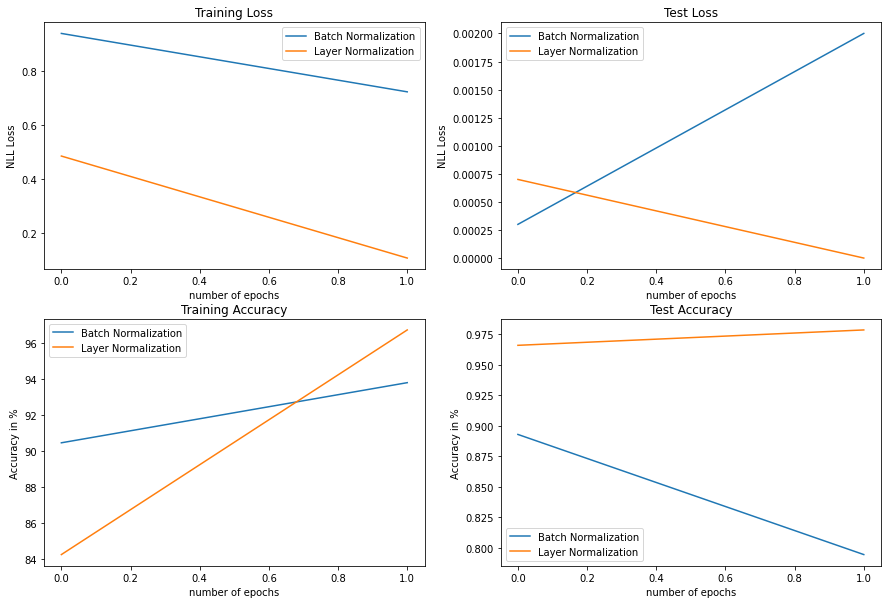

In [31]:
#@title Plot Images
mapping_dict = {'bn':'Batch Normalization', 'ln': 'Layer Normalization', 'gn': 'Group Normalization'}
fig, axs = plt.subplots(2,2,figsize=(15,10))
for norm in list_norm:
  axs[0, 0].plot(dict_training_output[norm]['train_loss'], label = mapping_dict[norm])
  axs[0, 0].set_title("Training Loss")
  axs[0, 0].set_xlabel('number of epochs', fontsize=10)
  axs[0, 0].set_ylabel('NLL Loss', fontsize=10)
  axs[0, 0].legend()
  axs[1, 0].plot(dict_training_output[norm]['train_accuracy'], label = mapping_dict[norm])
  axs[1, 0].set_title("Training Accuracy")
  axs[1, 0].set_xlabel('number of epochs', fontsize=10)
  axs[1, 0].set_ylabel('Accuracy in %', fontsize=10)
  axs[1, 0].legend()
  axs[0, 1].plot(dict_training_output[norm]['val_loss'], label = mapping_dict[norm])
  axs[0, 1].set_title("Test Loss")
  axs[0, 1].set_xlabel('number of epochs', fontsize=10)
  axs[0, 1].set_ylabel('NLL Loss', fontsize=10)
  axs[0, 1].legend()
  axs[1, 1].plot(dict_training_output[norm]['val_accuracy'], label = mapping_dict[norm])
  axs[1, 1].set_title("Test Accuracy")
  axs[1, 1].set_xlabel('number of epochs', fontsize=10)
  axs[1, 1].set_ylabel('Accuracy in %', fontsize=10)
  axs[1, 1].legend()
plt.plot()

In [38]:
#@title Misclassified images

def get_misclassified_images(model, device, test_loader, num_image = 10):
  model.eval() # setting the model in evaluation mode
  list_misclassified_images = []
  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      output_match_list = preds.eq(labels.view_as(preds)).squeeze().tolist()
      labels_list = labels.squeeze().tolist()
      preds_list = preds.squeeze().tolist()
      # print(preds.eq(labels.view_as(preds)))
      # print(preds.eq(labels.view_as(preds)).size())
      # print (torch.squeeze(preds.eq(labels.view_as(preds))))
      # print( labels[8])
      # print( images[8])
      # print(output_match_list)
      for index, bool_value in enumerate(output_match_list):
        if not bool_value:
          # print(index)
          list_misclassified_images.append((images[index],labels[index],preds[index]))
          if len(list_misclassified_images) == num_image: break
      if len(list_misclassified_images) == num_image: break
  return list_misclassified_images

In [ ]:
# list_misclassified_images = get_misclassified_images(model,device, test_loader,num_image = 10)

In [39]:
dict_misclassified_images ={}
for norm in list_norm:
  dict_misclassified_images[norm] = get_misclassified_images(dict_training_output[norm]['model'],device, test_loader,num_image = 10)

In [17]:
# t = 4
# print(list_misclassified_images[t][1].cpu().item(),list_misclassified_images[t][2].cpu().item() )

10

In [40]:
# Plotting misclassified images function
def plot_misclassified_images (list_misclassified_images):
  figure = plt.figure(figsize = (10,5))
  for index in range(1, len(list_misclassified_images) + 1): 
      plt.subplot(2, int(len(list_misclassified_images)/2), index)
      plt.axis('off')
      plt.imshow(list_misclassified_images[index-1][0].cpu().numpy().squeeze(), cmap='gray_r')
      plt.title(f'Actual - {list_misclassified_images[index-1][1]} \nPredicted - {list_misclassified_images[index-1][2].cpu().item()}')



=========Misclassified Images for norm Batch Normalization.========
=========Misclassified Images for norm Layer Normalization.========


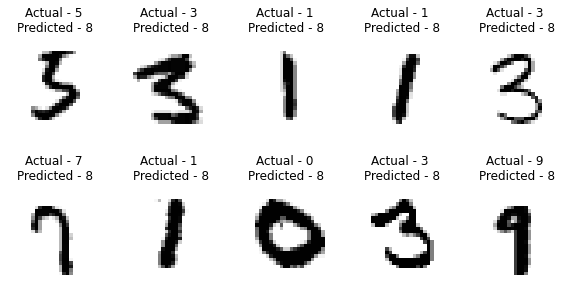

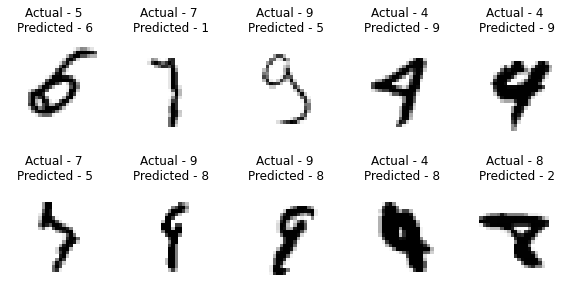

In [41]:
#@title Plot Misclassified Images
for norm in list_norm:
  print(f'=========Misclassified Images for {mapping_dict[norm]}.========')
  plot_misclassified_images(dict_misclassified_images[norm])